/media/timofey/aad run/coniferest15/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/timofey/aad run/coniferest15/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1, Train Loss: 38.164993551173815
Epoch: 1, Validation Loss: 15.675545677262345
Epoch: 2, Train Loss: 14.089655148085727
Epoch: 2, Validation Loss: 12.633709919952967
Epoch: 3, Train Loss: 11.834946839842942
Epoch: 3, Validation Loss: 11.676473364528688
Epoch: 4, Train Loss: 10.84453857270423
Epoch: 4, Validation Loss: 10.536341680516612
Epoch: 5, Train Loss: 10.019763608921451
Epoch: 5, Validation Loss: 9.586507087851054
Epoch: 6, Train Loss: 8.091325449095569
Epoch: 6, Validation Loss: 7.467473016749013
Epoch: 7, Train Loss: 7.1615719665072985
Epoch: 7, Validation Loss: 7.083953437860381
Epoch: 8, Train Loss: 6.759432692484387
Epoch: 8, Validation Loss: 6.581531390324918
Epoch: 9, Train Loss: 6.439886984497777
Epoch: 9, Validation Loss: 6.417395025419832
Epoch: 10, Train Loss: 6.106487195288672
Epoch: 10, Validation Loss: 5.987315831642133
Epoch: 11, Train Loss: 5.926126592113914
Epoch: 11, Validation Loss: 5.8654782064744255
Epoch: 12, Train Loss: 5.799695888169055
Epoch: 12,

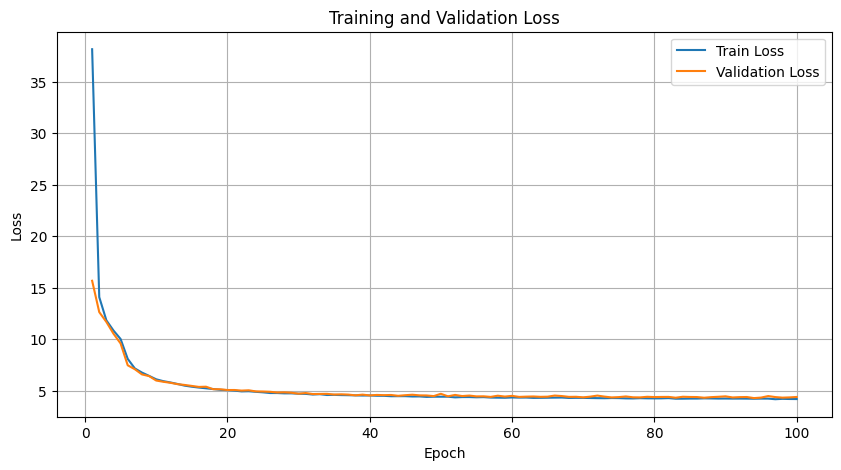

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from coniferest.datasets import plasticc_gp
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Уменьшаем вариативность весов
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Загрузка данных
data, metadata = plasticc_gp()
data = data[:, :-11]
filtered_data = data[(data >= -1).all(axis=1) & (data <= 1).all(axis=1)]
filtered_metadata = metadata[(data >= -1).all(axis=1) & (data <= 1).all(axis=1)]

# Определение VAE
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Linear(32, 16),
            # nn.ReLU()
        )
        self.mu_layer = nn.Linear(32, latent_dim)
        self.logvar_layer = nn.Linear(32, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            # nn.Linear(32, 64), 
            # nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Функция потерь для VAE
def loss_function(recon_x, x, mu, logvar, kld_weight=0.5, recon_weight=1.0):
     # Проверка logvar
    if torch.isnan(logvar).any() or torch.isinf(logvar).any():
        print("Обнаружены некорректные значения в logvar.")
        return torch.tensor(0.0, requires_grad=True)  # Возвращаем нулевой тензор
    BCE = recon_weight * nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = kld_weight * -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Подготовка данных
class MyDataset(Dataset):
    def __init__(self, filtered_data):
        self.data = filtered_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

# Разбиваем данные на обучающую и валидационную выборки с сохранением пропорций аномалий
train_data, val_data, train_labels, val_labels = train_test_split(
    filtered_data[filtered_metadata == 1], filtered_metadata[filtered_metadata == 1], test_size=0.3, random_state=seed)

train_dataset = MyDataset(train_data)
val_dataset = MyDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Параметры модели
input_dim = data.shape[1]
# latent_dim = 2
# latent_dim = 4
# latent_dim = 8
latent_dim = 16

# Создание модели
model = VariationalAutoencoder(input_dim, latent_dim)

# Оптимизация
# optimizer = optim.SGD(model.parameters(), lr=0.000025)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
epochs = 100
kld_weight = 0.5
recon_weight = 1.0

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar, kld_weight, recon_weight)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}")

    # Оценка на валидационной выборке
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar, kld_weight, recon_weight)
            val_loss += loss.item()
    
    val_loss /= len(val_dataloader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch: {epoch+1}, Validation Loss: {val_loss}")

# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Получение скрытых представлений
latent_representations = []

model.eval()
with torch.no_grad():
    for sample in filtered_data:
        sample_tensor = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        mu, logvar = model.encode(sample_tensor)
        latent_representations.append(mu.numpy())  # Преобразуем в NumPy массив

# Преобразуем список в двумерный массив NumPy
latent_representations = np.array(latent_representations).squeeze()  # Удаляем лишние размерности



Индексы 100 образцов с наименьшей плотностью вероятности: [ 390 2243 3788  252 4367 2510 2109 4533 1490 2134 1194 1003 4238 3228
 4437 4163  119 1815 5377 6523 4603 2580 1689 3040 2324 4300 2049 5938
 1308 1823 2745 5418  829  519 1319 6856 2030 6075 6411 4450 6551 3463
 1786 2954 6280 6310 4748 5078 2227 3166 2173 4973 2755 6235 1283 5631
 6642 3167 3137 3652 5937 5526 2025 2937 6308  716 1579 3175 1139 6937
 5051 2603 1373 6627 4966  399 5685 1322 7049 4752 1436 4888  755 6009
 7157 2309 4234 2581 5958  891 2662  255 5039 1087 6859 1219 6125 2001
 1455 1979]
Плотности вероятности для этих образцов: [2.29039833e-139 1.04634998e-138 4.60824543e-131 4.07401175e-130
 7.28774434e-128 1.45334172e-123 8.18374250e-111 6.96384429e-097
 8.00118629e-088 2.20903325e-081 5.49346008e-076 6.10514641e-072
 2.82183088e-068 1.63991193e-066 1.15209878e-065 9.17067081e-065
 6.39757871e-062 5.23723469e-058 5.34156311e-054 2.44612264e-053
 9.13576276e-053 1.08601382e-052 2.22842177e-052 7.00572967e-052
 9

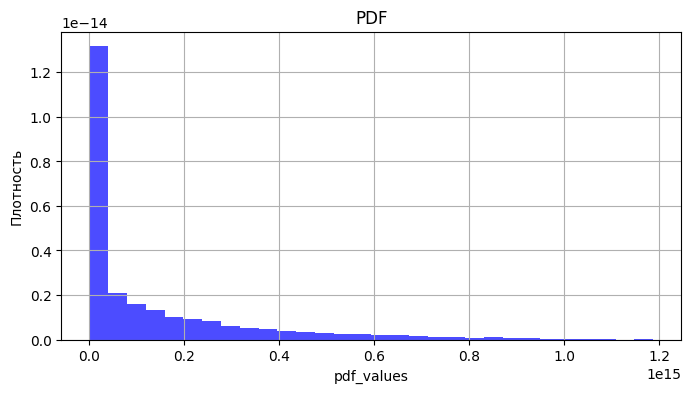

In [5]:
# Параметры многомерного нормального распределения
mean = np.mean(latent_representations[filtered_metadata == 1], axis=0) #np.zeros(latent_representations.shape[1]) 
cov = np.cov(latent_representations[filtered_metadata == 1], rowvar=False) #np.eye(latent_representations.shape[1]) 

# Вычисление плотности вероятности
pdf_values = multivariate_normal.pdf(latent_representations, mean=mean, cov=cov, allow_singular=True)

# Сортировка по убыванию и выбор 100 самых маленьких
sorted_indices = np.argsort(pdf_values)  # Сортируем по возрастанию
top_100_indices = sorted_indices[:100]
top_100_pdf_values = pdf_values[top_100_indices]

# Получаем соответствующие объекты и метки
top_100_objects = filtered_data[top_100_indices]
top_100_labels = filtered_metadata[top_100_indices]

# Вывод результатов
print("Индексы 100 образцов с наименьшей плотностью вероятности:", top_100_indices)
print("Плотности вероятности для этих образцов:", top_100_pdf_values)
print("Метки для этих образцов:", top_100_labels)

# Построение гистограммы для плотности распределения (должен быть пик)
plt.figure(figsize=(8, 4))
plt.hist(pdf_values, bins=30, density=True, alpha=0.7, color='blue')
plt.title('PDF')
plt.xlabel('pdf_values')
plt.ylabel('Плотность')
plt.grid()
plt.show()

In [6]:
sum(top_100_labels==-1)

np.int64(32)